<a href="https://colab.research.google.com/github/ldselvera/Fraud_Detection_Deep_Learning/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

import keras
from keras import regularizers, optimizers, losses
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv1D, Dense, Flatten, Activation, UpSampling1D, MaxPooling1D, ZeroPadding1D
from keras.layers import Flatten, Dropout, BatchNormalization, MaxPool1D

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn import datasets, decomposition, preprocessing

from mpl_toolkits.mplot3d import Axes3D

print(tf.__version__)

2.5.0


## Dataset

In [ ]:
#import dataset from csv

#Modify with your own path
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fraud/creditcard.csv")

In [ ]:
#preview of the data
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

### Check for missing values (Null/NaN)

In [ ]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### Imbalanced data

In [ ]:
# Number of instances per class 
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [ ]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


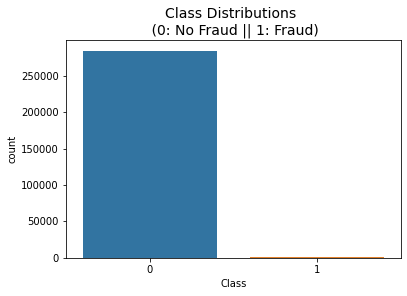

In [ ]:
sns.countplot('Class', data=df)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

In [ ]:
def show_pca_df(df):
	x = df[df.columns[1:30]].to_numpy()
	y = df[df.columns[30]].to_numpy()

	x = preprocessing.MinMaxScaler().fit_transform(x)
	pca = decomposition.PCA(n_components=3)
	pca_result = pca.fit_transform(x)
	print(pca.explained_variance_ratio_)

	pca_df = pd.DataFrame(data=pca_result, columns=['pc_1', 'pc_2', 'pc_3'])
	pca_df = pd.concat([pca_df, pd.DataFrame({'label': y})], axis=1)

	ax = Axes3D(plt.figure(figsize=(8, 8)))
	ax.scatter(xs=pca_df['pc_1'], ys=pca_df['pc_2'], zs=pca_df['pc_3'], c=pca_df['label'], s=25)
	ax.set_xlabel("pc_1")
	ax.set_ylabel("pc_2")
	ax.set_zlabel("pc_3")
	plt.show()

[0.13501016 0.12577772 0.12031404]


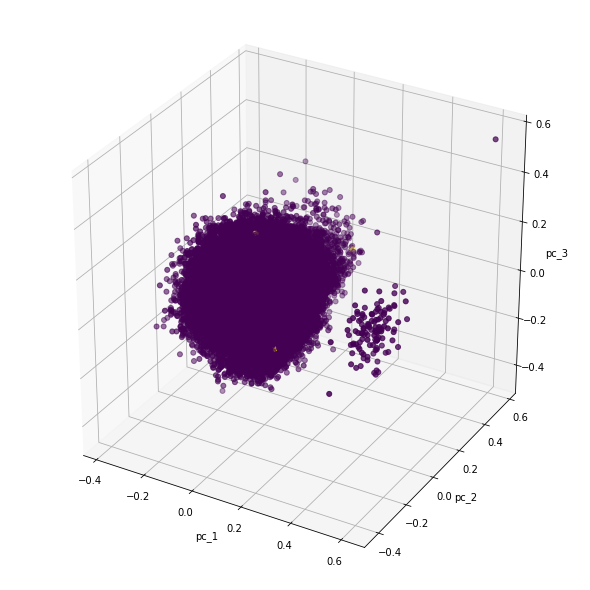

In [ ]:
show_pca_df(df)

### Subsampling

In [ ]:
#Split fraud and normal transactions
fraud_data = df[df['Class']==1]
non_fraud_data = df[df["Class"]==0]

#Subsample according to the size of fraud transactions
non_fraud_data1 = non_fraud_data.sample(1500)

#Rejoin fraud and normal transactions
final_data = fraud_data.append(non_fraud_data1,ignore_index=True)


In [ ]:
print('No Frauds', round(final_data['Class'].value_counts()[0]/len(final_data) * 100,2), '% of the dataset')
print('Frauds', round(final_data['Class'].value_counts()[1]/len(final_data) * 100,2), '% of the dataset')

No Frauds 75.3 % of the dataset
Frauds 24.7 % of the dataset


Distribution of the Classes in the subsample dataset
0    0.753012
1    0.246988
Name: Class, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


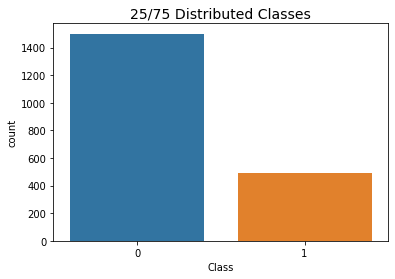

In [ ]:
print('Distribution of the Classes in the subsample dataset')
print(final_data['Class'].value_counts()/len(final_data))

sns.countplot('Class', data=final_data)
plt.title('25/75 Distributed Classes', fontsize=14)
plt.show()

In [ ]:
final_data['Class'].value_counts()

0    1500
1     492
Name: Class, dtype: int64

[0.20577961 0.14728955 0.09800458]


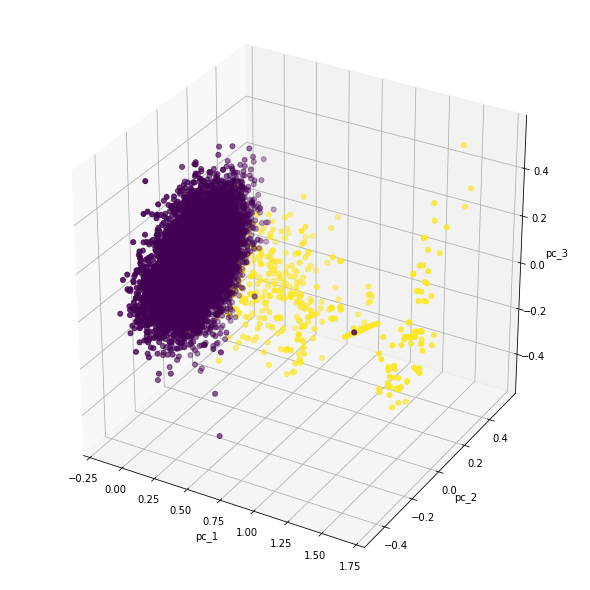

In [ ]:
df_anomaly = df[df[df.columns[30]] > 0]
df_normal = df[df[df.columns[30]] == 0].sample(n=df_anomaly.size, random_state=1, axis='index')
df = pd.concat([ df_anomaly, df_normal])

show_pca_df(df)

## Splitting Data

In [ ]:
data_set = pd.concat([non_fraud_data[:1500], fraud_data])

x_train, x_test = train_test_split(data_set, test_size = 0.2)

x_train = x_train.sort_values(by=['Time'])
x_test = x_test.sort_values(by=['Time'])

y_train = x_train["Class"]
y_test = x_test["Class"]

x_train = x_train.drop("Class",axis=1)
x_test = x_test.drop("Class",axis=1)

x_test.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80
20,16.0,0.694885,-1.361819,1.029221,0.834159,-1.191209,1.309109,-0.878586,0.445290,-0.446196,0.568521,1.019151,1.298329,0.420480,-0.372651,-0.807980,-2.044557,0.515663,0.625847,-1.300408,-0.138334,-0.295583,-0.571955,-0.050881,-0.304215,0.072001,-0.422234,0.086553,0.063499,231.71
27,23.0,1.322707,-0.174041,0.434555,0.576038,-0.836758,-0.831083,-0.264905,-0.220982,-1.071425,0.868559,-0.641506,-0.111316,0.361485,0.171945,0.782167,-1.355871,-0.216935,1.271765,-1.240622,-0.522951,-0.284376,-0.323357,-0.037710,0.347151,0.559639,-0.280158,0.042335,0.028822,16.00
32,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,-0.484688,0.872490,0.851636,-0.571745,0.100974,-1.519772,-0.284376,-0.310524,-0.404248,-0.823374,-0.290348,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14
34,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,-0.482474,0.871800,0.853447,-0.571822,0.102252,-1.519991,-0.285912,-0.309633,-0.403902,-0.823743,-0.283264,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77
38,29.0,0.996370,-0.122589,0.546819,0.706580,0.134560,1.156995,-0.294561,0.407429,0.337863,-0.408150,0.682646,1.253720,0.391917,-0.037511,0.795302,-1.668211,1.322995,-2.830035,-1.463432,-0.203461,-0.076302,0.108867,0.162231,-0.575624,0.109795,0.373813,0.050552,0.005106,20.53
46,34.0,-0.291540,0.445575,1.249752,-1.735736,0.085756,-0.121924,0.407716,0.095309,0.815902,-1.491188,-0.846191,0.056533,-0.058954,0.151923,1.982595,-0.443295,-0.318251,0.064787,0.613505,-0.033522,-0.064906,-0.120449,-0.156526,-0.800213,-0.000620,-0.835203,0.131001,0.062896,18.95
47,34.0,0.201686,0.497483,1.373913,0.571405,-0.630658,-0.539659,-0.076270,-0.917106,0.270008,-0.480281,-0.512533,0.680906,0.089923,-0.157405,-0.588819,-0.477908,0.225389,-0.668680,-0.023599,-0.222303,0.718961,-0.171877,-0.166205,0.776471,0.818460,0.442547,0.142757,0.219238,9.99
52,36.0,-1.169422,1.158314,1.406800,0.860189,-0.103810,0.122035,0.264451,-0.108767,-0.181977,0.659593,0.456317,-0.097763,-0.346159,0.210182,2.345229,-1.172648,0.860019,-1.154224,0.858768,-0.120560,0.024498,-0.120153,0.212986,0.087536,-0.946530,0.226700,-0.810101,0.234957,7.99
62,41.0,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,0.757952,-0.448937,-0.660863,-1.308522,0.788864,0.320294,0.295404,-0.287878,-0.451453,-1.011446,-0.191050,0.011106,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,34.13


In [ ]:
input_shape = (x_train.shape[1], 1)

print("Shapes:\nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))
print("input_shape:{}\n".format(input_shape))

Shapes:
x_train:(1593, 30)
y_train:(1593,)

x_test:(399, 30)
y_test:(399,)

input_shape:(30, 1)



In [ ]:
y_train[:5]

0    0
1    0
3    0
2    0
5    0
Name: Class, dtype: int64

In [ ]:
def plot_learning_curve(history,epochs):
    
    epoch_range=range(1,epochs+1)
    plt.plot(epoch_range,history.history['accuracy'])
    plt.plot(epoch_range,history.history["val_accuracy"])
    plt.title("Model Accuracy")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend("train","val",loc="upper left")
    plt.show()
     
    plt.plot(epoch_range,history.history['loss'])
    plt.plot(epoch_range,history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train','Val'],loc='upper left')
    plt.show()

## Deep Neural Network

In [ ]:
DNN = Sequential([
Dense(input_dim = 30, units = 16, activation = 'relu'),
Dense(units = 24, activation = 'relu'),
Dropout(0.5),
Dense(units = 20, activation = 'relu'),
Dense(units = 24, activation = 'relu'),
Dense(units =1, activation = 'sigmoid'),])

In [ ]:
DNN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = DNN.fit(x_train, y_train, epochs = 25, validation_data = (x_test,y_test),verbose=1)

Epoch 1/25
50/50 [==============================] - 16s 14ms/step - loss: 20.6129 - accuracy: 0.2781 - val_loss: 4.2595 - val_accuracy: 0.2657
Epoch 2/25
50/50 [==============================] - 0s 3ms/step - loss: 6.8234 - accuracy: 0.3012 - val_loss: 2.3955 - val_accuracy: 0.3409
Epoch 3/25
50/50 [==============================] - 0s 3ms/step - loss: 4.7295 - accuracy: 0.3774 - val_loss: 3.0632 - val_accuracy: 0.3885
Epoch 4/25
50/50 [==============================] - 0s 3ms/step - loss: 4.5256 - accuracy: 0.3942 - val_loss: 1.3609 - val_accuracy: 0.5263
Epoch 5/25
50/50 [==============================] - 0s 4ms/step - loss: 4.3485 - accuracy: 0.4402 - val_loss: 0.4293 - val_accuracy: 0.7368
Epoch 6/25
50/50 [==============================] - 0s 3ms/step - loss: 3.2687 - accuracy: 0.4730 - val_loss: 0.6021 - val_accuracy: 0.6842
Epoch 7/25
50/50 [==============================] - 0s 3ms/step - loss: 2.5510 - accuracy: 0.5060 - val_loss: 0.1502 - val_accuracy: 1.0000
Epoch 8/25
50/50 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if __name__ == '__main__':


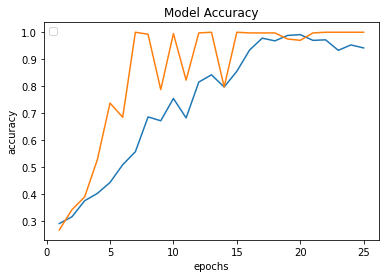

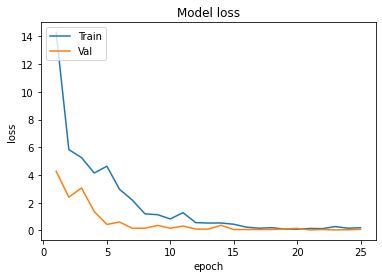

In [ ]:
plot_learning_curve(history, 25)

In [ ]:
score = DNN.evaluate(x_test, y_test)

13/13 [==============================] - 0s 2ms/step - loss: 0.0705 - accuracy: 1.0000


In [ ]:
y_pred = DNN.predict(x_test)
cm = confusion_matrix(y_test, y_pred.round())
print(cm)

[[301   0]
 [  0  98]]


In [ ]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       301
           1       1.00      1.00      1.00        98

    accuracy                           1.00       399
   macro avg       1.00      1.00      1.00       399
weighted avg       1.00      1.00      1.00       399



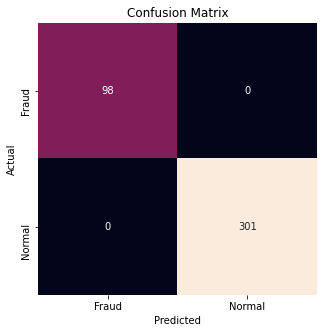

In [ ]:
labels = ["Fraud", "Normal"]

matrix = np.flip(cm)

plt.figure(figsize=(5, 5))
sns.heatmap(matrix, xticklabels=labels, yticklabels=labels,  annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Convolutional Neural Network

In [ ]:
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)
input_shape = (x_train.shape[1], 1)

print("Shapes:\nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))
print("input_shape:{}\n".format(input_shape))

Shapes:
x_train:(1593, 30, 1)
y_train:(1593,)

x_test:(399, 30, 1)
y_test:(399,)

input_shape:(30, 1)



In [ ]:
epochs=50
CNN=Sequential()

CNN.add(Conv1D(32,2,activation='relu',input_shape=x_train[0].shape))
CNN.add(BatchNormalization())
CNN.add(MaxPool1D(2))
CNN.add(Dropout(0.2))

CNN.add(Conv1D(64,2,activation='relu'))
CNN.add(BatchNormalization())
CNN.add(MaxPool1D(2))
CNN.add(Dropout(0.5))


#flattening layer
CNN.add(Flatten())
CNN.add(Dense(64,activation="relu"))
CNN.add(Dropout(0.5))

#final layer
CNN.add(Dense(1,activation="sigmoid"))

In [ ]:
CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 32)            96        
_________________________________________________________________
batch_normalization (BatchNo (None, 29, 32)            128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 13, 64)            4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 64)            256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 64)            

In [ ]:
CNN.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history =CNN.fit(x_train,y_train,epochs=epochs, validation_data = (x_test,y_test),verbose=1)

Epoch 1/50
50/50 [==============================] - 7s 17ms/step - loss: 0.4485 - accuracy: 0.8051 - val_loss: 0.2180 - val_accuracy: 0.9875
Epoch 2/50
50/50 [==============================] - 0s 6ms/step - loss: 0.0856 - accuracy: 0.9749 - val_loss: 0.0639 - val_accuracy: 0.9975
Epoch 3/50
50/50 [==============================] - 0s 7ms/step - loss: 0.1185 - accuracy: 0.9557 - val_loss: 0.0198 - val_accuracy: 1.0000
Epoch 4/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0231 - accuracy: 0.9956 - val_loss: 0.0117 - val_accuracy: 1.0000
Epoch 5/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0129 - accuracy: 0.9978 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 6/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0132 - accuracy: 0.9961 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 7/50
50/50 [==============================] - 0s 8ms/step - loss: 0.0196 - accuracy: 0.9948 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 8/50
50/50 [=

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if __name__ == '__main__':


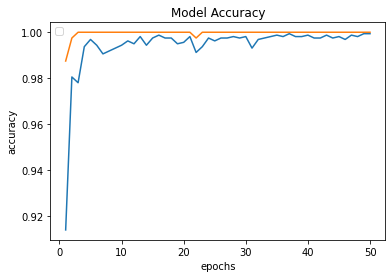

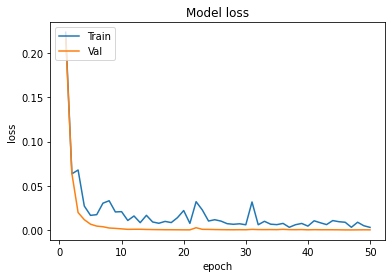

In [ ]:
plot_learning_curve(history, 50)

In [ ]:
final_acc = CNN.evaluate(x_train,y_train, verbose=0)
print('Test loss:', final_acc[0])
print('Test accuracy:', final_acc[1])

Test loss: 0.0016173010226339102
Test accuracy: 0.9993722438812256


In [ ]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       301
           1       1.00      1.00      1.00        98

    accuracy                           1.00       399
   macro avg       1.00      1.00      1.00       399
weighted avg       1.00      1.00      1.00       399



In [ ]:
y_pred = CNN.predict(x_test)
cm = confusion_matrix(y_test, y_pred.round())
print(cm)

[[301   0]
 [  0  98]]


In [ ]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       301
           1       1.00      1.00      1.00        98

    accuracy                           1.00       399
   macro avg       1.00      1.00      1.00       399
weighted avg       1.00      1.00      1.00       399



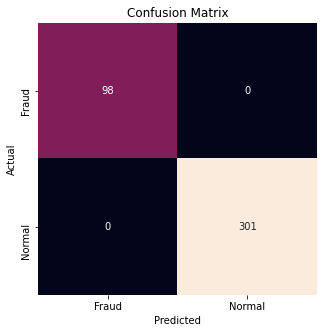

In [ ]:
labels = ["Fraud", "Normal"]

matrix = np.flip(cm)

plt.figure(figsize=(5, 5))
sns.heatmap(matrix, xticklabels=labels, yticklabels=labels,  annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Temporal Convolutional Encoder-Decoder

In [ ]:
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)
input_shape = (x_train.shape[1], 1)

y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)

print("Shapes:\nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))
print("input_shape:{}\n".format(input_shape))

Shapes:
x_train:(1593, 30, 1)
y_train:(1593, 2)

x_test:(399, 30, 1)
y_test:(399, 2)

input_shape:(30, 1)



In [ ]:
input_layer = Input(shape=(input_shape ))

### ENCODING STAGE
# ENCODING STAGE

#filters: the dimensionality of the output space
#kernel size: the length of the 1D convolution window
#dilation rate: dilation rate to use for dilated convolution
#padding: causal (dilated) convolutions, useful when modeling temporal data where the model should not violate the temporal order
#strides: the stride length of the convolution
#kernel regularizer: The L2 regularization penalty is computed as: loss = l2 * reduce_sum(square(x))
#activation ReLU: the rectified linear unit activation function
#this returns the standard ReLU activation: max(x, 0)
# Pairs of causal 1D convolutional layers and pooling layers comprising the encoding stage
conv_1 = Conv1D(filters=int(input_shape[0]), kernel_size=2, dilation_rate=1,
                padding='causal', strides=1,input_shape=input_shape,
                kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(input_layer)

pool_1 = MaxPooling1D(pool_size=2, strides=2)(conv_1)

conv_2 = Conv1D(filters=int(input_shape[0] / 2), kernel_size=2, dilation_rate=1,
                padding='causal',strides=1, kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(pool_1)

pool_2 = MaxPooling1D(pool_size=2, strides=3)(conv_2)

conv_3 = Conv1D(filters=int(input_shape[0] / 3), kernel_size=2, dilation_rate=1,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(pool_2)


### OUTPUT OF ENCODING STAGE
encoder = Dense(int(input_shape[0] / 6), activation='relu')(conv_3)

### DECODING STAGE
# Pairs of upsampling and causal 1D convolutional layers comprising the decoding stage
upsample_1 = UpSampling1D(size=3)(encoder)

conv_4 = Conv1D(filters=int(input_shape[0]/3), kernel_size=2, dilation_rate=1,
                padding='causal',strides=1, kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(upsample_1)

upsample_2 = UpSampling1D(size=2)(conv_4)

conv_5 = Conv1D(filters=int(input_shape[0]/2), kernel_size=2, dilation_rate=1,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.05),
                activation='relu')(upsample_2)

zero_pad_1 = ZeroPadding1D(padding=(0,1))(conv_5)

conv_6 = Conv1D(filters=int(input_shape[0]), kernel_size=2, dilation_rate=1,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.05),
                activation='relu')(zero_pad_1)


### Output of decoding stage flattened and passed through softmax to make predictions
flat = Flatten()(conv_6)

output_layer = Dense(2, activation='softmax')(flat)

TCN = Model(inputs=input_layer, outputs=output_layer)

TCN.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizers.Adam(lr=0.002),
           metrics=["accuracy"])

TCN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 1)]           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 30)            90        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 15, 30)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 15, 15)            915       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 15)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 5, 10)             310       
_________________________________________________________________
dense_7 (Dense)              (None, 5, 5)              55    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history =TCN.fit(x_train, y_train, epochs=25, verbose=1, validation_data=(x_test, y_test))

Epoch 1/25
50/50 [==============================] - 4s 24ms/step - loss: 7.0296 - accuracy: 0.4491 - val_loss: 1.6765 - val_accuracy: 1.0000
Epoch 2/25
50/50 [==============================] - 0s 9ms/step - loss: 1.6394 - accuracy: 0.9974 - val_loss: 1.5168 - val_accuracy: 1.0000
Epoch 3/25
50/50 [==============================] - 0s 9ms/step - loss: 1.5020 - accuracy: 0.9980 - val_loss: 1.4160 - val_accuracy: 1.0000
Epoch 4/25
50/50 [==============================] - 0s 8ms/step - loss: 1.4069 - accuracy: 0.9983 - val_loss: 1.3383 - val_accuracy: 1.0000
Epoch 5/25
50/50 [==============================] - 0s 9ms/step - loss: 1.3403 - accuracy: 0.9966 - val_loss: 1.2674 - val_accuracy: 1.0000
Epoch 6/25
50/50 [==============================] - 0s 10ms/step - loss: 1.2577 - accuracy: 0.9989 - val_loss: 1.2000 - val_accuracy: 1.0000
Epoch 7/25
50/50 [==============================] - 0s 9ms/step - loss: 1.1952 - accuracy: 0.9985 - val_loss: 1.1392 - val_accuracy: 1.0000
Epoch 8/25
50/50 [

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if __name__ == '__main__':


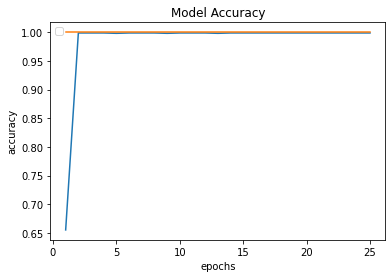

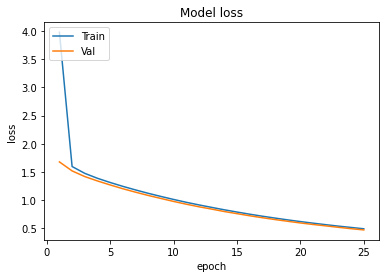

In [ ]:
plot_learning_curve(history, 25)

In [ ]:
score = TCN.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4689672291278839
Test accuracy: 1.0


In [ ]:
preds = TCN.predict(x_test)
y_pred = np.round(preds)
print(y_pred)
auc = roc_auc_score( y_pred, y_test)
print("AUC: {:.2%}".format (auc))

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       301
           1       1.00      1.00      1.00        98

   micro avg       1.00      1.00      1.00       399
   macro avg       1.00      1.00      1.00       399
weighted avg       1.00      1.00      1.00       399
 samples avg       1.00      1.00      1.00       399



In [ ]:
y_pred2 = np.argmax(y_pred, axis=1)
y_test2 = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test2, y_pred2.round())
print(cm)

[[301   0]
 [  0  98]]


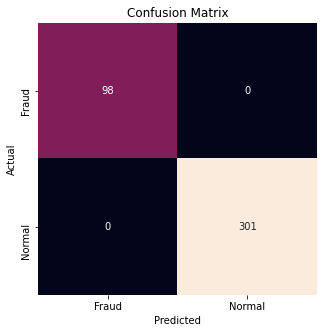

In [ ]:
labels = ["Fraud", "Normal"]

matrix = np.flip(cm)

plt.figure(figsize=(5, 5))
sns.heatmap(matrix, xticklabels=labels, yticklabels=labels,  annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()